# Multiplicity determination with Calibr

Note: Uses the R3BRoot NeuLAND module. As this module is compiled with ROOT, it is available in Python by `import ROOT` if the environment variables are set.

In [1]:
import numpy as np
import pandas as pd
import os
import ROOT

Welcome to JupyROOT 6.16/00


## Example Fit / Calibration
We can run the full calibraion from python, with some amount of yucky syntax

In [2]:
def calibrate_calibr(infiles, outfile, max_neutrons, image):
    cal = ROOT.Neuland.Neutron2DCalibr(max_neutrons)
    for file in infiles:
        print(f"Processing {file} ...", flush=True)
        cal.AddClusterFile(file)
    vslope = ROOT.std.vector("double")()
    vslope += [0.04, 0.001, 0.001, 10]
    vdistance = ROOT.std.vector("double")()
    vdistance += [10, 0.5, 6, 60]
    vdist_off = ROOT.std.vector("double")()
    vdist_off += [3, 0.5, 3, 6]
    cal.Optimize(vslope, vdistance, vdist_off)
    cal.WriteParameterFile(outfile)
    cal.Draw(image)

Processing simulation/training_600AMeV_30dp_1n.digi.root ...
Processing simulation/training_600AMeV_30dp_2n.digi.root ...
Processing simulation/training_600AMeV_30dp_3n.digi.root ...
Processing simulation/training_600AMeV_30dp_4n.digi.root ...
Processing simulation/training_600AMeV_30dp_5n.digi.root ...
Neutron2DCalibr::Optimize done!
[INFO] ***  R3BNeulandNeutron2DPar written to ROOT file   version: 1
--------------------------------------------------------------------------------
--------------  actual containers in runtime database  -------------------------
R3BNeulandNeutron2DPar                         Neuland Neutron 2D Parameters
--------------  runs, versions  ------------------------------------------------
run id
  container                                        1st-inp    2nd-inp    output
run: 1
  R3BNeulandNeutron2DPar                                -1         -1          1
--------------  input/output  --------------------------------------------------
first input: none


Info in <TCanvas::Print>: png file data/600AMeV_30dp_5n.png has been created


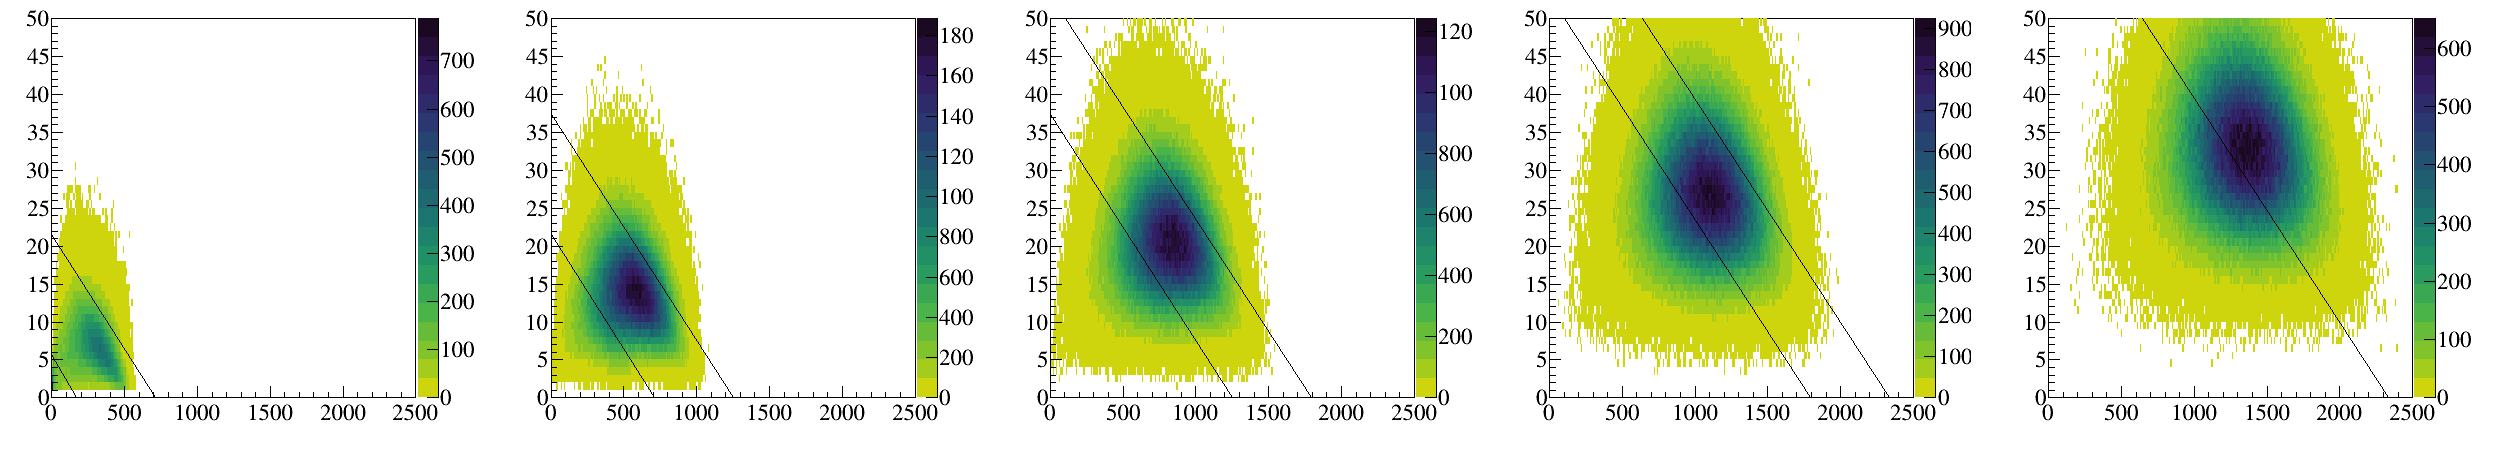

In [3]:
max_neutrons = 5
num_dp = 30

infiles = [
    f"simulation/training_600AMeV_{num_dp}dp_{neutrons}n.digi.root"
    for neutrons in range(1, max_neutrons + 1)
]
outfile = f"data/600AMeV_{num_dp}dp_{max_neutrons}n.ncut.root"
image = f"data/600AMeV_{num_dp}dp_{max_neutrons}n.png"
os.remove(outfile)
calibrate_calibr(infiles, outfile, max_neutrons, image)

## Example Prediction

In [7]:
file = ROOT.TFile.Open(f"data/600AMeV_{num_dp}dp_{max_neutrons}n.ncut.root")
para = file.Get("R3BNeulandNeutron2DPar")

testdata = pd.read_pickle(f"data/600AMeV_{num_dp}dp.trifeature.pkl").sample(frac=1)
y_true = testdata[["nPH"]].values.ravel()

y_pred = np.array(
    [
        para.GetNeutronMultiplicity(row["Edep"], row["nClus"])
        for _, row in testdata.iterrows()
    ]
)

print(list(zip(y_true, y_pred))[0:50])

[(5, 5), (5, 4), (4, 3), (2, 3), (1, 1), (4, 5), (1, 1), (1, 1), (2, 3), (1, 1), (4, 5), (5, 4), (4, 3), (4, 4), (5, 4), (5, 4), (1, 1), (4, 4), (2, 2), (3, 3), (3, 3), (2, 2), (4, 3), (3, 3), (2, 2), (1, 1), (3, 2), (3, 3), (3, 4), (4, 4), (1, 1), (3, 3), (5, 5), (4, 5), (3, 3), (4, 5), (3, 4), (4, 3), (3, 3), (3, 4), (2, 2), (3, 3), (4, 4), (4, 3), (5, 3), (4, 4), (3, 2), (4, 5), (3, 3), (3, 3)]


Warning in <TFile::Init>: file data/600AMeV_30dp_5n.ncut.root probably not closed, trying to recover
Info in <TFile::Recover>: data/600AMeV_30dp_5n.ncut.root, recovered key R3BNeulandNeutron2DPar:R3BNeulandNeutron2DPar at address 256
Info in <TFile::Recover>: data/600AMeV_30dp_5n.ncut.root, recovered key FairRtdbRun:1 at address 893
Info in <TFile::Recover>: data/600AMeV_30dp_5n.ncut.root, recovered key TH2D:hPH0 at address 1080
Info in <TFile::Recover>: data/600AMeV_30dp_5n.ncut.root, recovered key TH2D:hPH1 at address 2033
Info in <TFile::Recover>: data/600AMeV_30dp_5n.ncut.root, recovered key TH2D:hPH2 at address 6454
Info in <TFile::Recover>: data/600AMeV_30dp_5n.ncut.root, recovered key TH2D:hPH3 at address 15189
Info in <TFile::Recover>: data/600AMeV_30dp_5n.ncut.root, recovered key TH2D:hPH4 at address 27983
Info in <TFile::Recover>: data/600AMeV_30dp_5n.ncut.root, recovered key TH2D:hPH5 at address 43378
Warning in <TFile::Init>: successfully recovered 8 keys


In [8]:
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, 6))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, 6), normalize="true")
print(cmrel)

0.75566711478018
[[ 24164      0      0      0      0      0]
 [ 54586 902851  65054      2      0      0]
 [   891 126562 776989 115984    110      0]
 [    10   6687 201014 681778 129157    569]
 [     0    217  19610 269282 597305 125670]
 [     0      5   1073  37152 294663 568184]]
[[1.    0.    0.    0.    0.    0.   ]
 [0.053 0.883 0.064 0.    0.    0.   ]
 [0.001 0.124 0.761 0.114 0.    0.   ]
 [0.    0.007 0.197 0.669 0.127 0.001]
 [0.    0.    0.019 0.266 0.59  0.124]
 [0.    0.    0.001 0.041 0.327 0.631]]


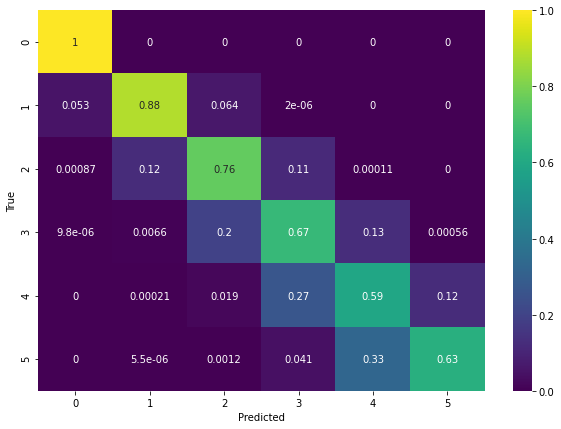

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True");